<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave-Sentence-Embedding-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples,adjusted_rand_score, homogeneity_score, completeness_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import KernelPCA

In [ ]:
#%pip install umap-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)

In [ ]:
train.head()

original_text  \
ix                                                      
0   There is manuscript evidence that Austen conti...   
1   In a remarkable comparative analysis , Mandaea...   
2   Before Persephone was released to Hermes , who...   
3   Cogeneration plants are commonly found in dist...   
4   Geneva -LRB- , ; , ; , ; ; -RRB- is the second...   

                                      lemmatized_text  d_chall_score  \
ix                                                                     
0   there be manuscript evidence that austen conti...       8.236551   
1   in a remarkable comparative analysis mandaean ...      12.320171   
2   before persephone be release to hermes who hav...       6.594628   
3   cogeneration plant be commonly find in distric...       7.015012   
4   geneva lrb rrb be the secondmostpopulous city ...       9.847729   

    aoa_mean  aoa_min  aoa_max  conc_rating_mean  conc_rating_min  \
ix                                                                  
0   5.809310     3.57    12.12          2.495517             1.33   
1   7.499286     2.89    11.94          2.251429             1.46   
2   5.231351     2.78    11.17          2.537222             1.43   
3   6.742000     3.56    11.53          3.429643             1.52   
4   5.455000     3.69    12.62          2.399333             1.43   

    conc_rating_max  num_lemmas  label  
ix                                      
0              4.57        37.0      1  
1              3.77        21.0      1  
2              4.86        42.0      1  
3              4.93        32.0      1  
4              4.79        28.0      1

In [4]:
sample_df = train.groupby('label').apply(lambda x: x.sample(50000, random_state=99))
sample_df.index = sample_df.index.get_level_values(1)
sample_df.head()

original_text  \
ix                                                          
256892  He studied art in Berlin , Essen , and Munich ...   
302461  There are paw prints of cave bears . There are...   
336641  The album also won the band a 2003 Swedish Gra...   
336467                      Communist Hungary , 1946-1989   
413140  Both his teaching and his textbook were instru...   

                                          lemmatized_text  d_chall_score  \
ix                                                                         
256892  he study art in berlin essen and munich before...       8.097500   
302461  there be paw print of cave bear there be also ...       1.780475   
336641  the album also win the band a 2003 swedish gra...       6.714850   
336467                         communist hungary 19461989      15.938800   
413140  both he teach and he textbook be instrumental ...       8.356977   

         aoa_mean  aoa_min  aoa_max  conc_rating_mean  conc_rating_min  \
ix                                                                       
256892   5.320769     2.89    12.22          2.663077             1.33   
302461   5.568750     3.58    10.71          2.933333             1.43   
336641   5.029231     2.89     7.74          2.855833             1.43   
336467  13.220000    13.22    13.22          3.500000             3.50   
413140   6.015652     2.89    11.84          2.730909             1.43   

        conc_rating_max  num_lemmas  label  
ix                                          
256892             4.92        20.0      0  
302461             4.96        16.0      0  
336641             4.91        16.0      0  
336467             3.50         3.0      0  
413140             4.93        27.0      0

In [ ]:
sample_df.label.value_counts()

0    50000
1    50000
Name: label, dtype: int64

In [5]:
#!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.5 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [6]:
sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])

In [10]:
# My gridsearch-ish attempt at running k-means.  This routine will
# create a dictionary containing the cluster numbers, scores and 
# saves the best model found (as identified by score)

def find_best_kmeans(X,n_clus_lst):
 
  m = {'cluster':[],
       'score':[],
       'wg':[],
       'hg' :[],
       'comp':[],
       'davies_bouldin':[]}
  best_model = None


  fig, ax = plt.subplots(3,3, figsize=(20,20))
  fig.suptitle('K-Means Clustering')
  ax = ax.flatten()

  for idx, k in enumerate(n_clus_lst):
    km = KMeans(n_clusters=k,max_iter=500,
                random_state=99)
    km.fit(X)
    score = silhouette_score(X,km.labels_,
                    random_state=99)
    
    hg = homogeneity_score(sample_df.label, km.labels_)
    comp = completeness_score(sample_df.label, km.labels_)
    davies = davies_bouldin_score(X_std, km.labels_ )

    scatter = ax[idx].scatter(X_pca[:,0],X_pca[:,1], 
                          c=km.labels_,s=50, cmap='viridis')
    ax[idx].set_title(f"k={k}")
    ax[idx].set_xlabel("X0"); 
    ax[idx].set_ylabel("X1")

    fig.colorbar(scatter, ax=ax[idx])


    m['cluster'].append(k)
    if best_model == None:
      best_model = km
    elif score > np.max(m['score']):
      best_model = km    
    m['score'].append(score)
    m['wg'].append(km.inertia_)
    m['hg'].append(hg)
    m['comp'].append(comp)
    m['davies_bouldin'].append(davies)

  return m, best_model


def plot_clusters(feature_one, feature_two, labels,title):
  # routine to plot out the clusters
  plt.figure(figsize=(10,10))
  plt.title(title)
  plt.xlabel("PCA Feature 1")
  plt.ylabel("PCA Feature 2")
  sns.scatterplot(x=feature_one,
                  y=feature_two,
                  hue=labels,
                  alpha=.3,
                  );


          

In [ ]:
# old code
# X_std = StandardScaler().fit_transform(X)
# X_pca = PCA(n_components=5).fit_transform(X_std)

In [8]:

# Create a preprocessing pipeline for Clustering
preprocessor = Pipeline([('scaler', StandardScaler())
                        ])


In [ ]:
import seaborn as sns

TypeError: ignored

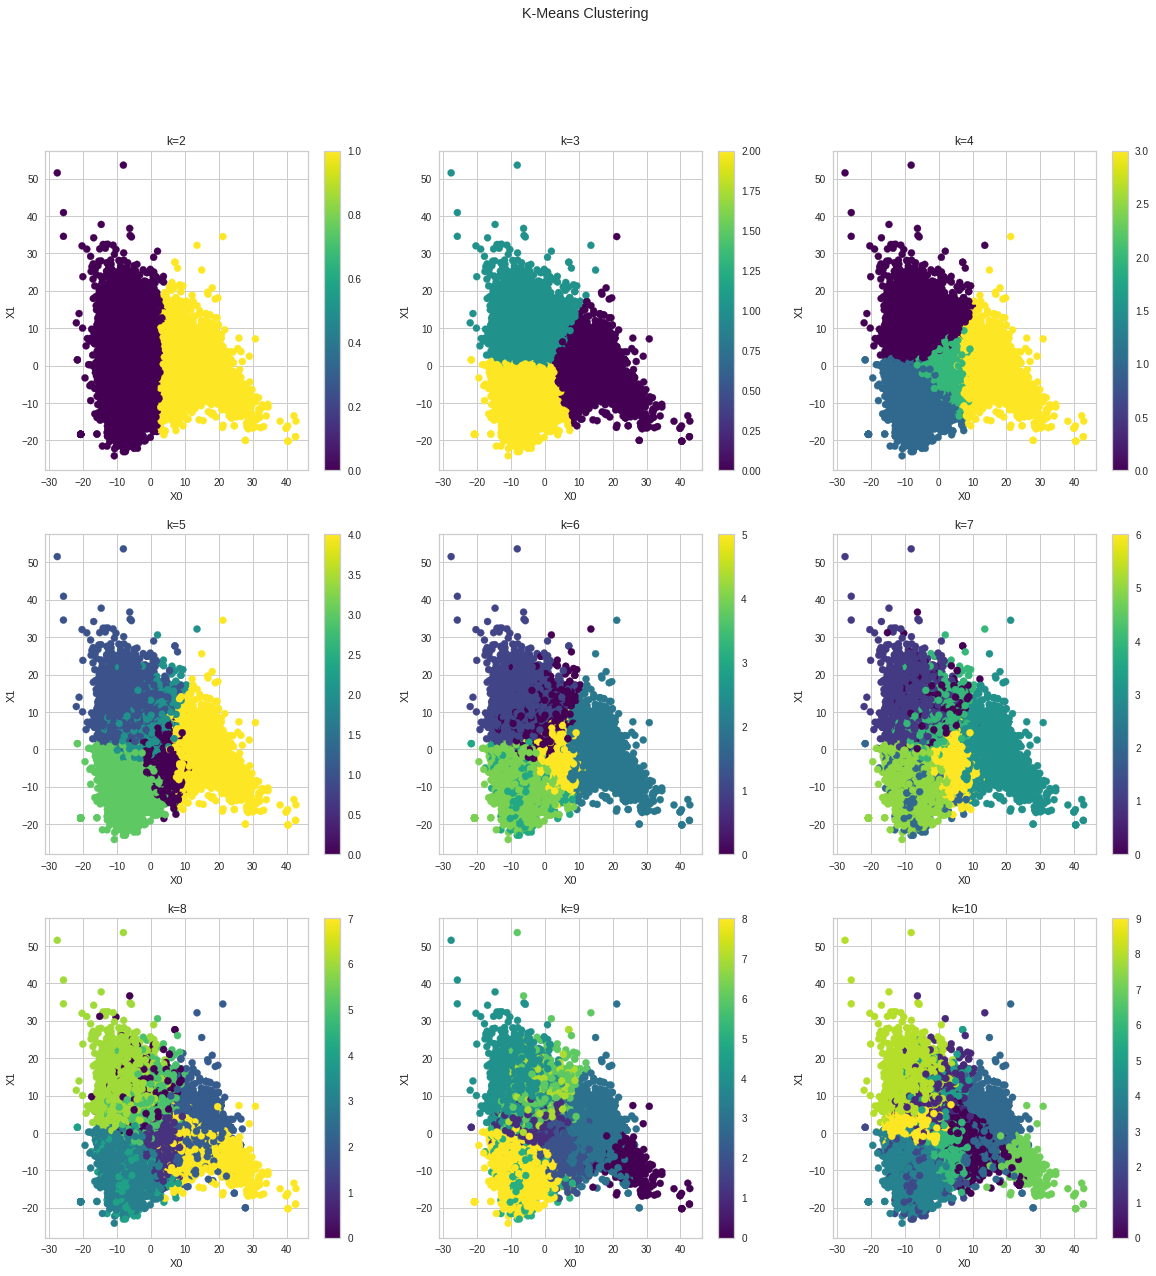

In [ ]:
X_std = preprocessor.fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_std)

# find best results from kmeans using standardized data
std_results, model = find_best_kmeans(X_std, [x for x in range(2,11)])
# print(f"Best Score: {np.max(std_results['score'])}")



In [ ]:
# Based on 50k sample
pd.DataFrame(std_results[0])
# plt.title("K-Means Elbow ")
# sns.lineplot(x=results['cluster'],
#              y=results['wg'])

cluster     score          wg        hg      comp  davies_bouldin
0        2  0.127840  27259694.0  0.000556  0.000645        2.701419
1        3  0.090569  25307998.0  0.005689  0.003667        2.637718
2        4  0.060690  24449058.0  0.009298  0.004831        2.905329
3        5  0.059048  23790410.0  0.012428  0.005493        2.965723
4        6  0.051663  23213804.0  0.013141  0.005254        2.840592
5        7  0.054165  22699924.0  0.014333  0.005328        2.740974
6        8  0.055254  22335834.0  0.014877  0.005251        2.783429
7        9  0.054069  21997760.0  0.016010  0.005459        2.686233
8       10  0.050920  21693114.0  0.015508  0.005054        2.682298

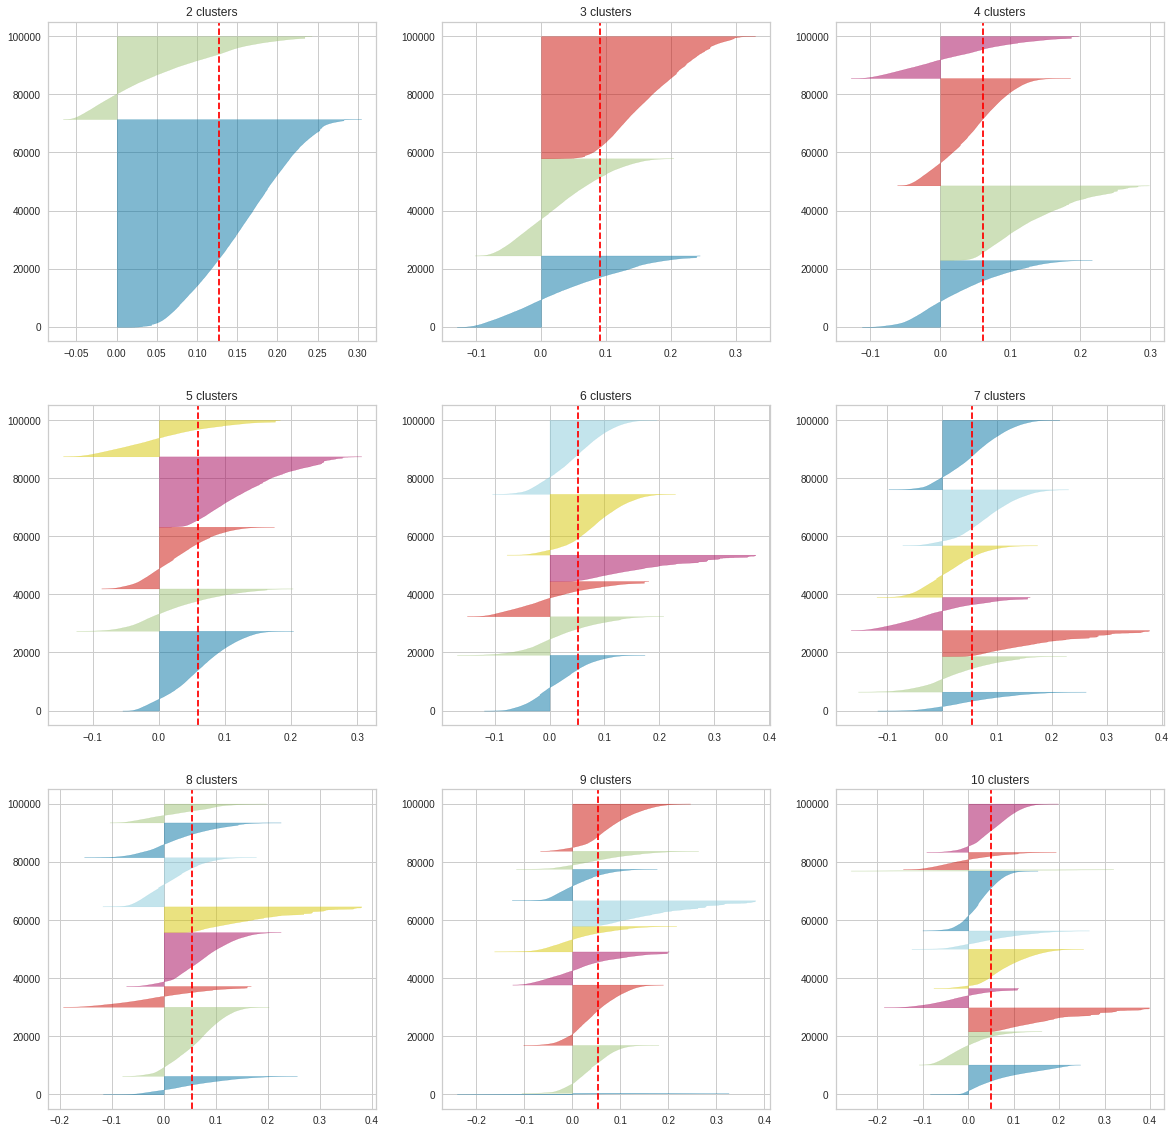

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(20,20))
ax = ax.flatten()
for idx, i in enumerate([x for x in range(2,11)]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, max_iter=500,
                random_state=99)

    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    ax[idx].set_title(f'{i} clusters')
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[idx])
    visualizer.fit(X_std)

In [ ]:
std_results

({'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'score': [0.12784041,
   0.0905692,
   0.060690448,
   0.05904769,
   0.051662974,
   0.054164816,
   0.055254128,
   0.0540686,
   0.050920304],
  'wg': [27259694.0,
   25307998.0,
   24449058.0,
   23790410.0,
   23213804.0,
   22699924.0,
   22335834.0,
   21997760.0,
   21693114.0],
  'hg': [0.0005563723202030294,
   0.0056886835312716716,
   0.009297887552298524,
   0.01242792184222493,
   0.013140815762314618,
   0.014332535196409242,
   0.01487726879546465,
   0.016010310821627752,
   0.015508287610221808],
  'comp': [0.0006449558560724054,
   0.003666726791115071,
   0.004830819582043011,
   0.005492751258690645,
   0.005254092591453274,
   0.0053277942984668435,
   0.005251243851414771,
   0.005459027577555687,
   0.00505390135709675],
  'davies_bouldin': [2.701418991036447,
   2.637718179423502,
   2.9053287246369366,
   2.9657231492086717,
   2.8405919327896245,
   2.740974004623741,
   2.7834287470695025,
   2.6862333053111147,
 

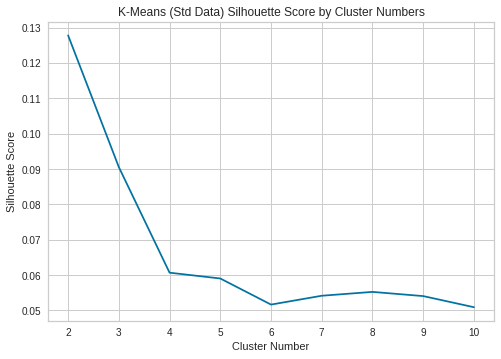

In [ ]:
plt.title("K-Means (Std Data) Silhouette Score by Cluster Numbers")
sns.lineplot(x=std_results[0]['cluster'],
             y=std_results[0]['score'])
plt.xlabel('Cluster Number')
plt.ylabel('Silhouette Score');


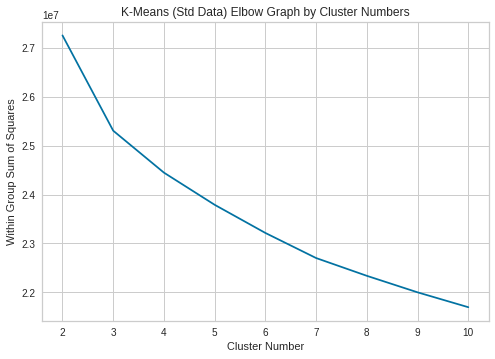

In [ ]:
plt.title("K-Means (Std Data) Elbow Graph by Cluster Numbers")
sns.lineplot(x=std_results[0]['cluster'],
             y=std_results[0]['wg'])
plt.xlabel('Cluster Number')
plt.ylabel('Within Group Sum of Squares');

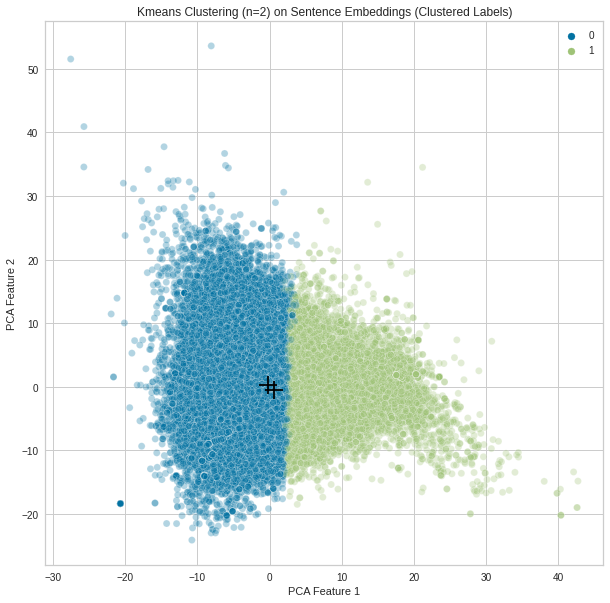

In [ ]:
best_model = std_results[1]

# plot out the data against Reduced Dimensions
km = best_model
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Clustered Labels)"
plot_clusters(feat_one,
              feat_two,
              km.labels_, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)

In [ ]:
top_sentences_by_cluster(X_std,std_km,sample_df)

 
 Cluster 0
--------------
 
top 10 closest sentences to cluster 0's center:
The roots of several demonstrations and meetings were planted in Folkets Hus , and as a result it was strongly linked to the great demonstration against unemployment in 1918 when workers stormed the Danish Stock Exchange -LRB- BÃ rsen -RRB- .
At the time , leading Virginia Republican figures such as Rep. William Branch Giles -LRB- in public -RRB- and Sen. John Taylor of Caroline -LRB- in private -RRB- actually were contemplating disunion , and the Virginia General Assembly chose this juncture for finally constructing a new state armory in Richmond , so there was some truth to the charge .
There must have been a naval battle somewhere near the mouth of the Nile , as shortly afterwards many Sherden are seen in the Pharaoh 's body-guard where they are conspicuous by their horned helmets with a ball projecting from the middle , their round shields and the great Naue II swords with which they are depicted in inscr

In [ ]:
# k-means found cluster separation however, the Silo score is around .5, 
# which doesn't imply great clustering separation.
# The plus signs are the respective cluster centers. Looking at what 
# sentences are clustered close by the centers for additional information

Best Score: 0.37914586067199707


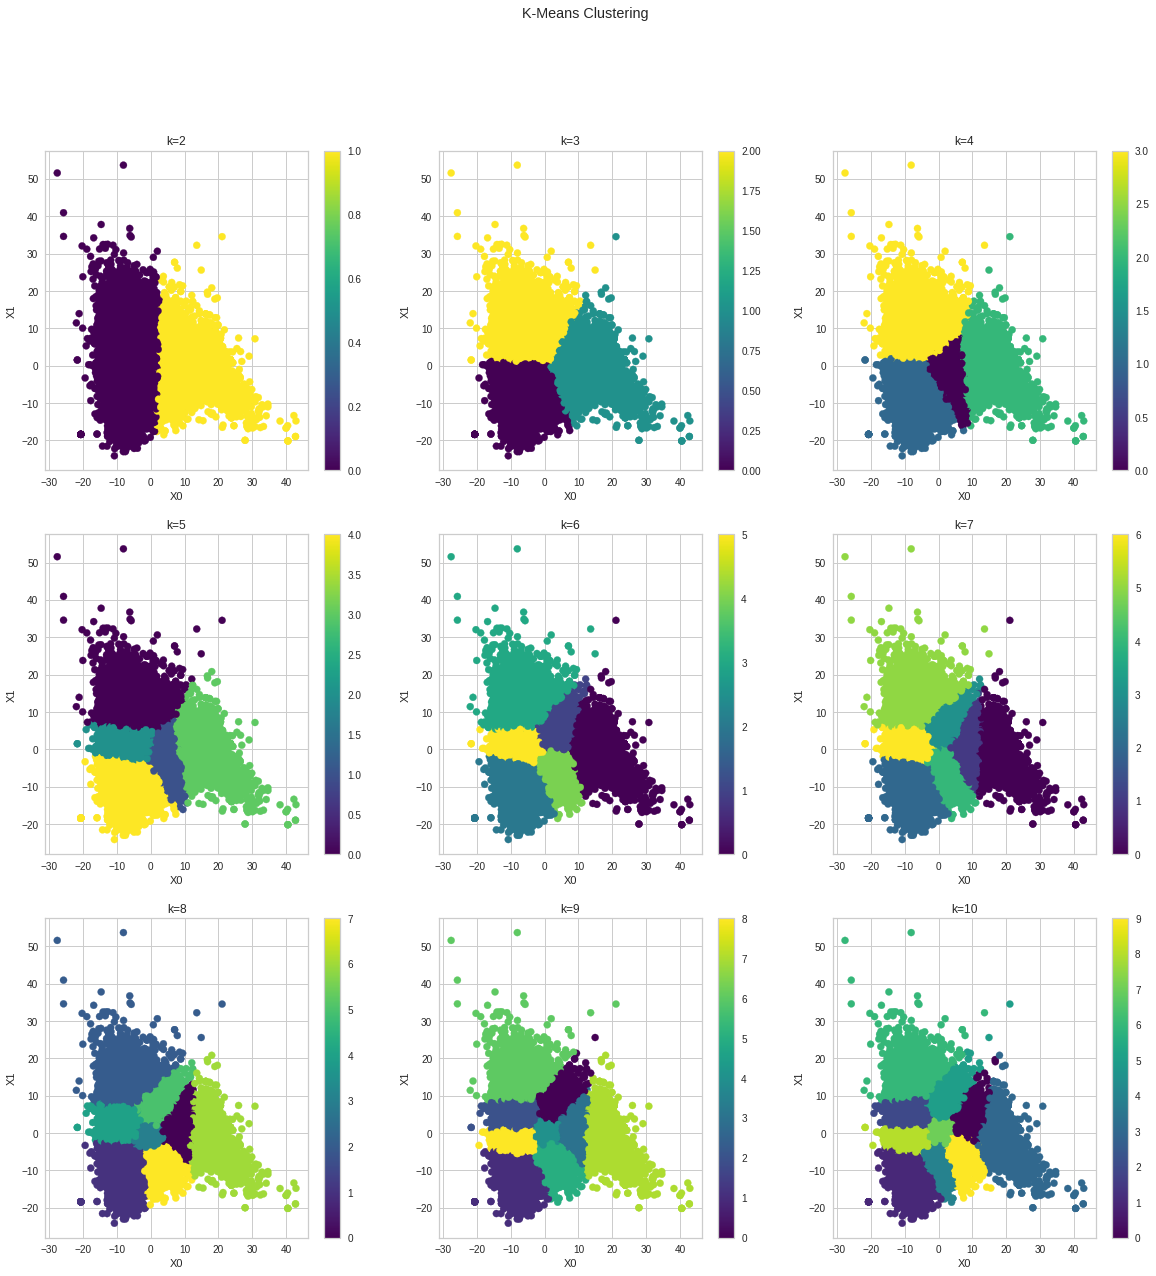

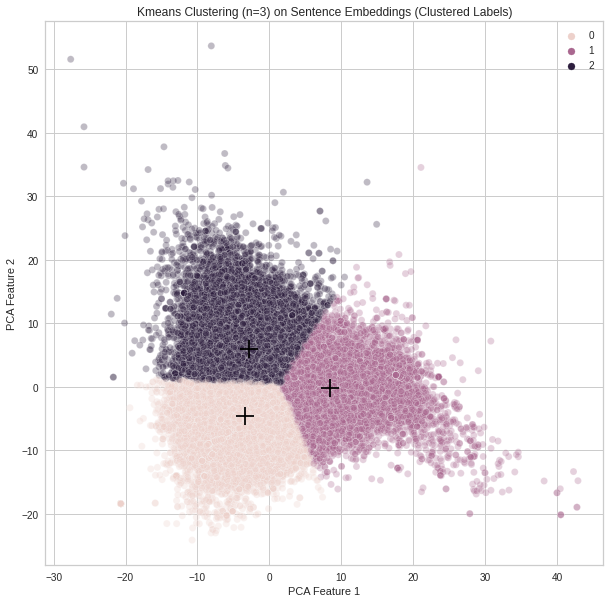

In [11]:
# Attempting using Reduced Dimensional Data from PCA 

X_std = preprocessor.fit_transform(X)
X_pca = PCA(n_components = 2).fit_transform(X_std)
results,best_pca_model = find_best_kmeans(X_pca, [x for x in range(2,11)])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(best_pca_model.cluster_centers_)


# plot out the data against Reduced Dimensions
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (n={best_pca_model.n_clusters}) on Sentence Embeddings (Clustered Labels)"
plot_clusters(feat_one,
              feat_two,
              best_pca_model.labels_, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)


In [ ]:
pd.DataFrame(results)

cluster     score           wg        hg      comp  davies_bouldin
0        2  0.346638  5132251.500  0.000725  0.000820        2.751398
1        3  0.379355  3202222.000  0.005969  0.003842        2.623726
2        4  0.346026  2501983.500  0.011289  0.005857        2.986351
3        5  0.329111  2082772.375  0.013176  0.005868        3.325156
4        6  0.339408  1750954.750  0.012712  0.005011        3.339841
5        7  0.332726  1536501.500  0.012487  0.004614        3.504760
6        8  0.329864  1378990.625  0.013498  0.004643        3.714549
7        9  0.324521  1242758.625  0.013327  0.004342        3.833967
8       10  0.327124  1128110.375  0.014600  0.004532        3.880564

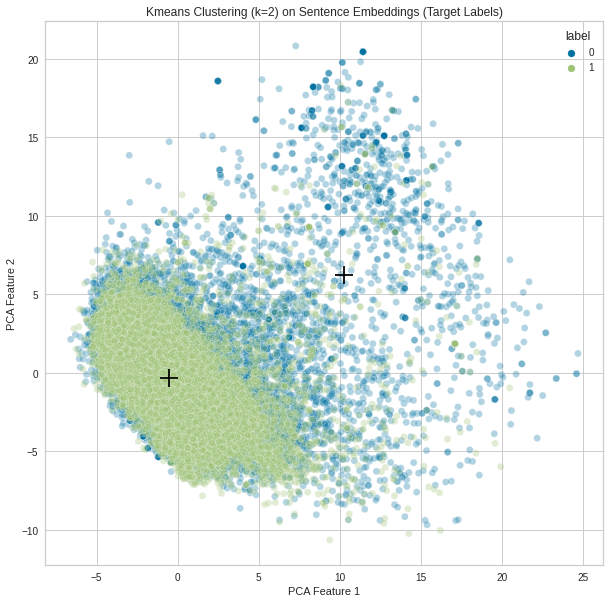

In [ ]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (k={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [12]:
# Results from clustering on reduced dimensions
r_df = pd.DataFrame(results)
r_df



cluster     score           wg        hg      comp  davies_bouldin
0        2  0.345004  5135014.500  0.000694  0.000779        2.763203
1        3  0.379146  3202567.750  0.006287  0.004021        2.618901
2        4  0.345747  2503012.500  0.011315  0.005870        2.988370
3        5  0.329190  2083655.250  0.013223  0.005889        3.326067
4        6  0.339620  1751307.375  0.012822  0.005052        3.341750
5        7  0.332733  1537870.000  0.012413  0.004586        3.504350
6        8  0.329842  1379968.625  0.013351  0.004595        3.710461
7        9  0.323124  1244190.250  0.013934  0.004528        3.866335
8       10  0.327611  1129209.500  0.014597  0.004533        3.874879

In [13]:
#code modified from https://stackoverflow.com/questions/69164379/how-to-find-the-index-of-the-point-closest-to-k-means-cluster-centers-using-skle
from scipy.spatial.distance import euclidean

def top_sentences_by_cluster(X,km,df):
  closest_pt_idx = []
  for iclust in range(km.n_clusters):
      # get all points assigned to each cluster:
      cluster_pts = X[km.labels_ == iclust]
      # get all indices of points assigned to this cluster:
      cluster_pts_indices = np.where(km.labels_ == iclust)[0]

      cluster_cen = km.cluster_centers_[iclust]
      top = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[:10]
      bottom = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[-10:]

      print(" ")
      print(f" Cluster {iclust}")
      print("--------------")
      # Print out the results for each cluster:
      print(f" ")
      print(f'top 10 closest sentences to cluster {iclust}\'s center:')
      for sent_vec in top:
        print(df.iloc[cluster_pts_indices[sent_vec]]['original_text'])
      print(" ")
      print(f'farthest sentences to cluster {iclust}\'s center:')
      for sent_vec in bottom[::-1]:
        print(df.iloc[cluster_pts_indices[sent_vec]]['original_text'])


In [14]:
top_sentences_by_cluster(X_pca,best_pca_model,sample_df)

 
 Cluster 0
--------------
 
top 10 closest sentences to cluster 0's center:
Croatia national football team is the national football team of Croatia .
The authoritarian King Carol II abdicated in 1940 , and succeeded by the National Legionary State , in which power was shared by Ion Antonescu and the Iron Guard .
The district was created in 1974 by merging the two districts of Eschwege and Witzenhausen , which had both existed with only slight modifications since 1821 .
The district was created in 1974 by merging the two districts of Eschwege and Witzenhausen , which had both existed with only slight modifications since 1821 .
He makes cameo appearances : in both The Legend of Zelda : A Link to the Past and The Legend of Zelda : Ocarina of Time , Mario appears on a portrait , and in Metal Gear Solid : The Twin Snakes he appears as a small statue .
The Rotfront , or '' Red Front , '' was the RotfrontkÃ mpferbund , the paramilitary organization of the Communist Party of Germany -LRB- KP

Best Score: 0.37914586067199707


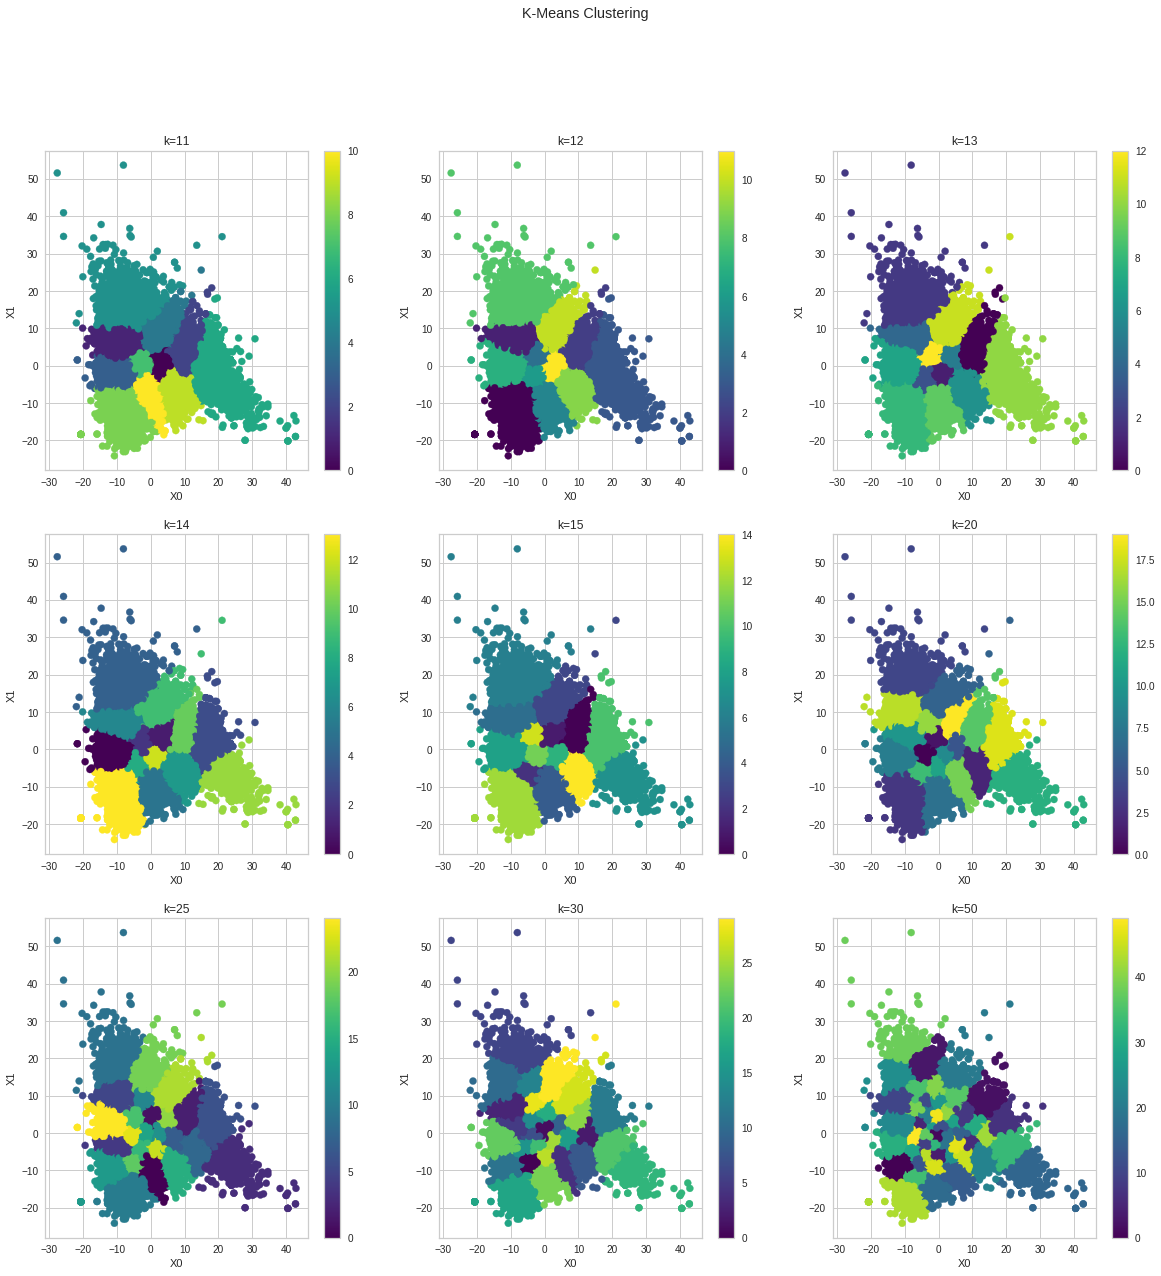

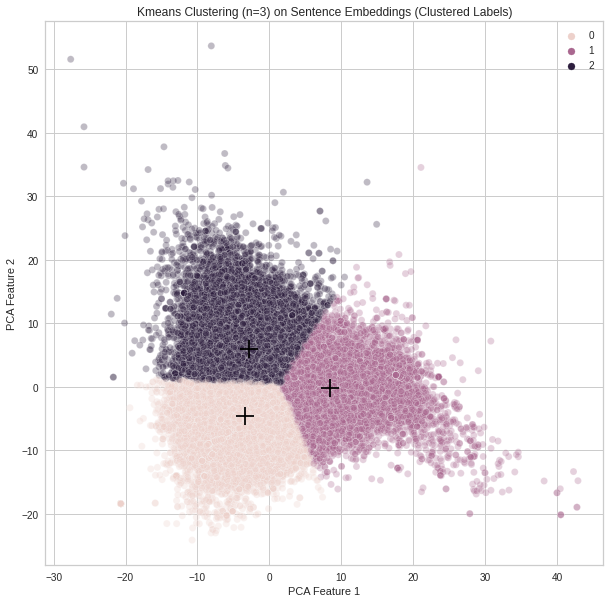

In [20]:
second_run_results,best_second_run_pca_model = find_best_kmeans(X_pca, [11,12,13,14,15,20,25,30,50])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(best_pca_model.cluster_centers_)


# plot out the data against Reduced Dimensions
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (n={best_pca_model.n_clusters}) on Sentence Embeddings (Clustered Labels)"
plot_clusters(feat_one,
            feat_two,
            best_pca_model.labels_, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)

In [24]:

df_final = pd.concat([r_df, pd.DataFrame(second_run_results)])
df_final.to_csv('drive/Shareddrives/Milestone 2/metrics/kmeans_pca.csv', 
                      sep='\t')

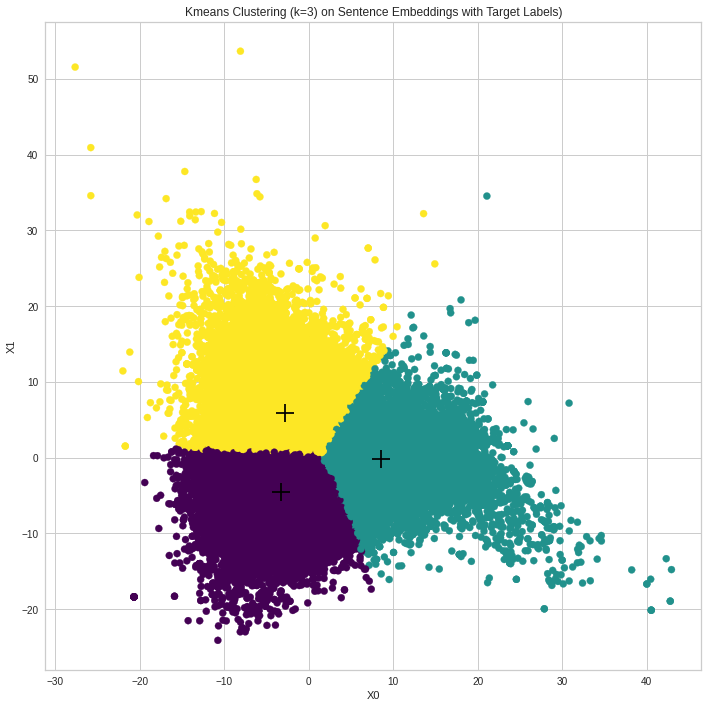

In [29]:
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (k=3) on Sentence Embeddings with Target Labels)"
plt.figure(figsize=(10,10))
plt.title(title)
plt.xlabel('X0')
plt.ylabel('X1')
scatter = plt.scatter(X_pca[:,0],X_pca[:,1], 
                          c=best_pca_model.labels_,s=50, cmap='viridis')

# plot_clusters(feat_one,
#             feat_two,
#             best_pca_model.labels_, title, 
#             c=sample_df.label,s=50, cmap='viridis')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)

plt.tight_layout()
plt.savefig('drive/Shareddrives/Milestone 2/kmeans_pca_best_by_cluster.png', dpi=900)

In [ ]:
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (k=3) on Sentence Embeddings with Target Labels)"
plt.figure(figsize=(10,10))
plt.title(title)
plt.xlabel('X0')
plt.ylabel('X1')
scatter = plt.scatter(X_pca[:,0],X_pca[:,1], 
                          c=.label,s=50, cmap='viridis')


plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)

plt.tight_layout()
plt.savefig('drive/Shareddrives/Milestone 2/kmeans_pca_best.png', dpi=900)

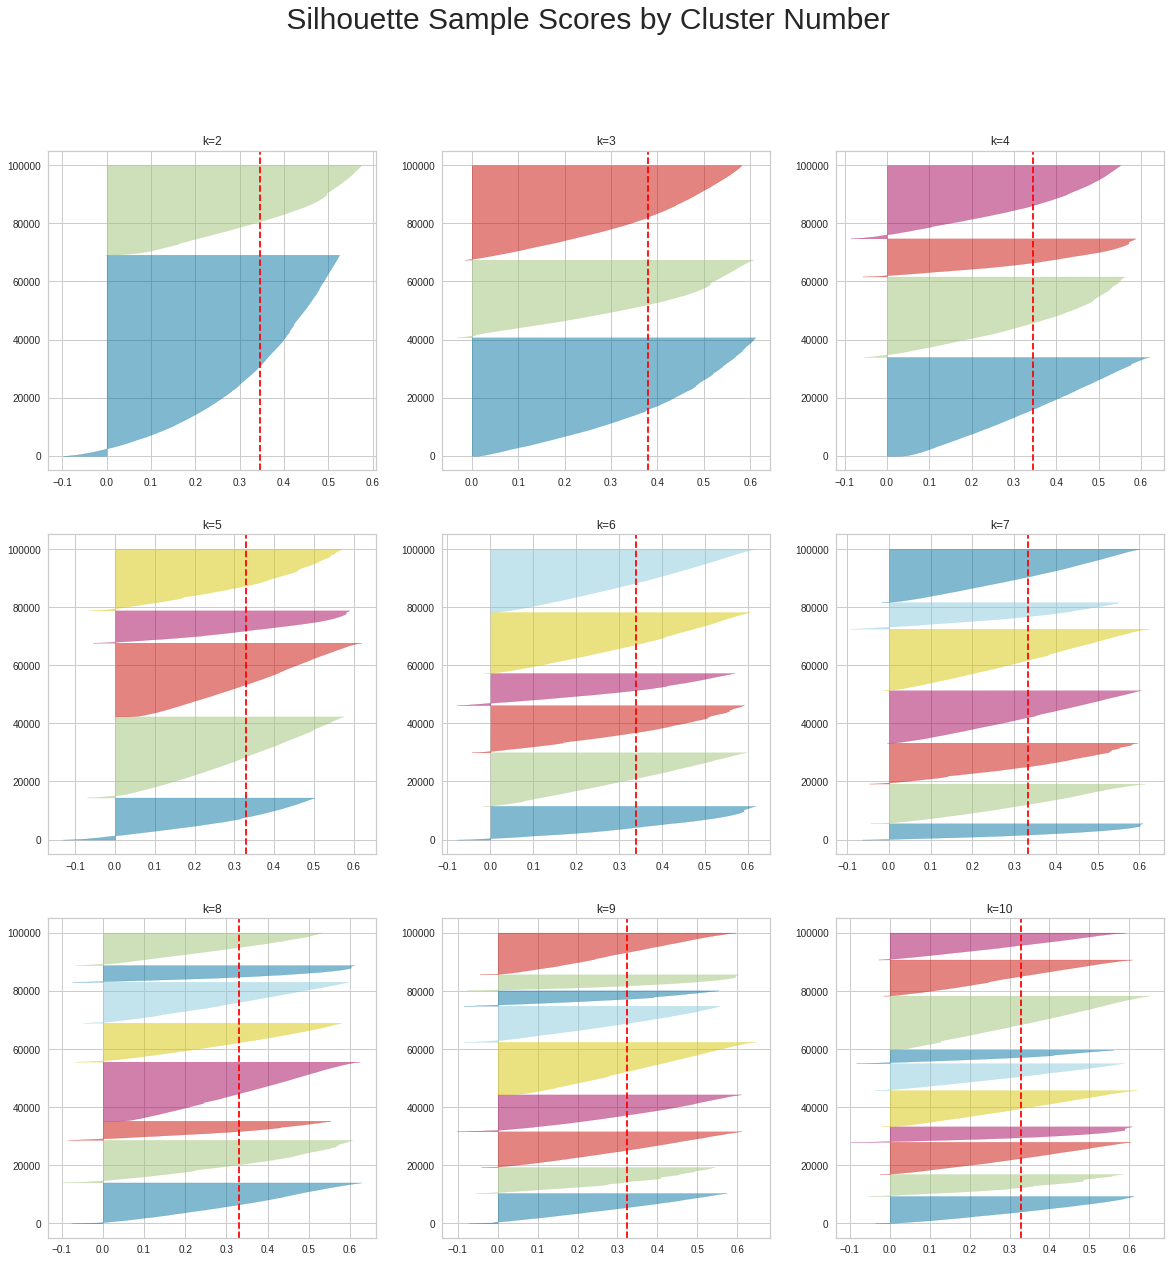

In [37]:
fig, ax = plt.subplots(3,3, figsize=(20,20))
ax = ax.flatten()
fig.suptitle(' Silhouette Sample Scores by Cluster Number ', fontsize=30)
for idx, i in enumerate([x for x in range(2,11)]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, max_iter=500,
                random_state=99)

    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    ax[idx].set_title(f'k={i}')
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[idx])
    visualizer.fit(X_pca)
    plt.savefig('drive/Shareddrives/Milestone 2/kmeans_silhouette_viz.png', dpi=900)

In [33]:
sample_df['cluster_label'] = best_pca_model.labels_

In [36]:
sample_df.to_csv('drive/Shareddrives/Milestone 2/Clustering/kmeans_membership_dataframe.csv',sep='\t')

In [ ]:
# It appears the K-Means algorithm found clusters based on 
# sentence length for the sentence embeddings.  
# Cluster 2 appears to only have 1 word in the original text

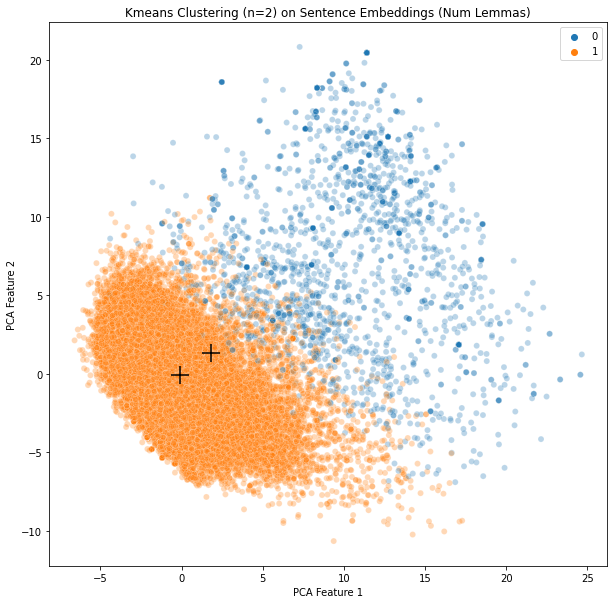

In [ ]:
# Plotting using num_lemmas for color (1 is 3 or more lemmas, otherwise 0)

gt_one_lemma = [1 if x >= 3 else 0 for x in sample_df.num_lemmas]

plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Num Lemmas)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=gt_one_lemma,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
# quick calculation to get how many numbers are in each text for confirmation
sample_df['numbers'] = [len([y for y in x.split(' ') if y.isdigit()]) for x in sample_df.lemmatized_text]


def proportion_nums(x):
  if x['numbers'] > 0:
      prop = x['numbers'] / x['num_lemmas']
      if prop < .25:
        return 0
      elif prop > .25 and prop < .5:
        return 1
      elif prop > .5 and prop < .75:
        return 2
      else:
        return 3
  else:
    return 0



sample_df['numbers'] = sample_df.apply(lambda x: proportion_nums(x), axis=1)

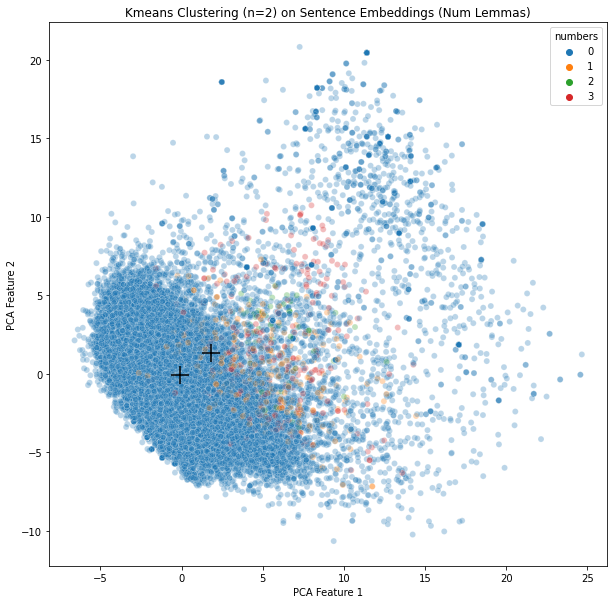

In [ ]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Num Lemmas)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.numbers,
                alpha=.3,
                legend='full',palette=sns.color_palette()[:4])

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
sample_df['emb_member'] = km.labels_

In [ ]:
sample_df = sample_df.reset_index(drop=True)


In [ ]:
(sample_df.groupby(['label','emb_member'])['lemmatized_text'].count())

label  emb_member
0      0              1928
       1             23072
1      0               352
       1             24648
Name: lemmatized_text, dtype: int64

In [ ]:
# There seems to be a disagreement with the first
# found cluster's membership and the label.  

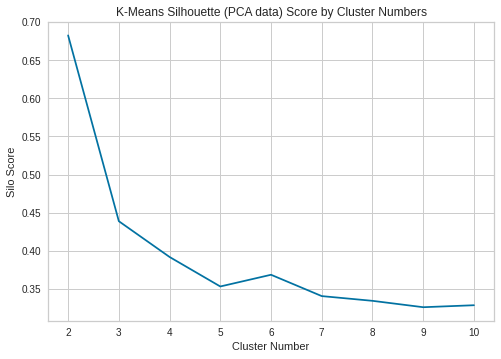

In [ ]:
plt.title("K-Means (PCA data) Silhouette Score by Cluster Numbers")
sns.lineplot(x=results['cluster'],
             y=results['score'])
plt.xlabel('Cluster Number')
plt.ylabel('Silo Score');

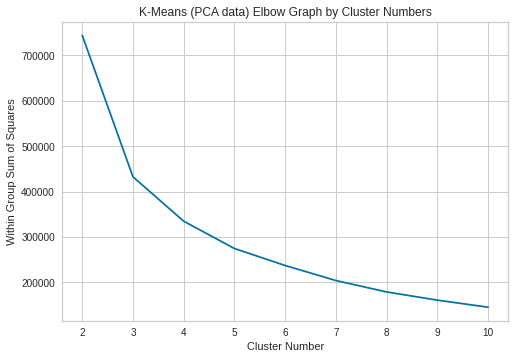

In [ ]:
plt.title("K-Means (PCA data) Elbow Graph by Cluster Numbers")
sns.lineplot(x=results['cluster'],
             y=results['wg'])
plt.xlabel('Cluster Number')
plt.ylabel('Within Group Sum of Squares');

In [ ]:
def find_best_clusters_kpca_value(kernel):
  if kernel == "":
    kernel = 'linear'

  metrics = {'gamma': [],
            'clusters': [],
            'score': []
            }

  for g in [.001,.01,1, 10,100]:
    X_kpca = KernelPCA(n_components=5,
                       kernel=kernel,
                       gamma=g).fit_transform(X_std)
    results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
    for idx, score in enumerate(results['score']):
      metrics['gamma'].append(g)
      metrics['clusters'].append(results['cluster'][idx])
      metrics['score'].append(score)

  return pd.DataFrame(metrics),metrics

In [ ]:
metrics_df,metrics = find_best_clusters_kpca_value('linear')
metrics_df.sort_values('score', ascending=False)[:5]

KeyboardInterrupt: ignored

In [ ]:
metrics_df,metrics = find_best_clusters_kpca_value('rbf')
metrics_df.sort_values('score', ascending=False)[:5]

gamma  clusters     score
36  100.0         6  0.999940
28   10.0         6  0.999940
20    1.0         6  0.999933
35  100.0         5  0.997894
27   10.0         5  0.997894

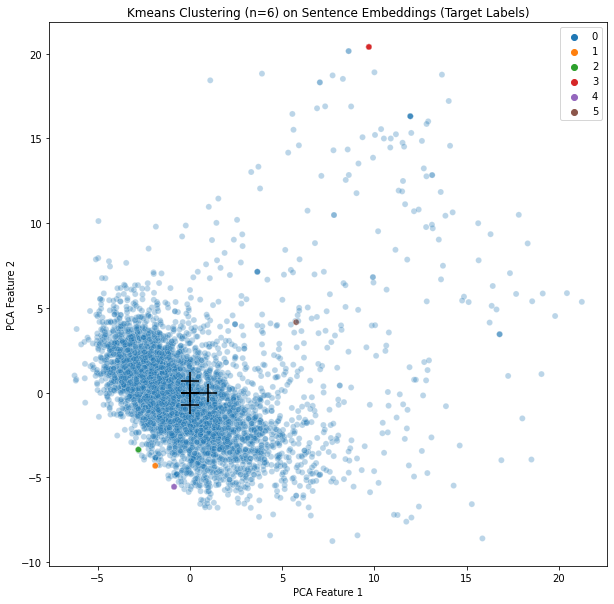

In [ ]:
X_kpca = KernelPCA(n_components=5, gamma=1, kernel='rbf').fit_transform(X_std)
results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=km.labels_,
                alpha=.3,
                palette=sns.color_palette()[:km.n_clusters],
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
# The K-Means Clustering with Kernel PCA Rbf function membership counts
np.bincount(km.labels_)

array([4960,    8,    7,   11,    8,    6])

In [ ]:
#!pip install ipympl

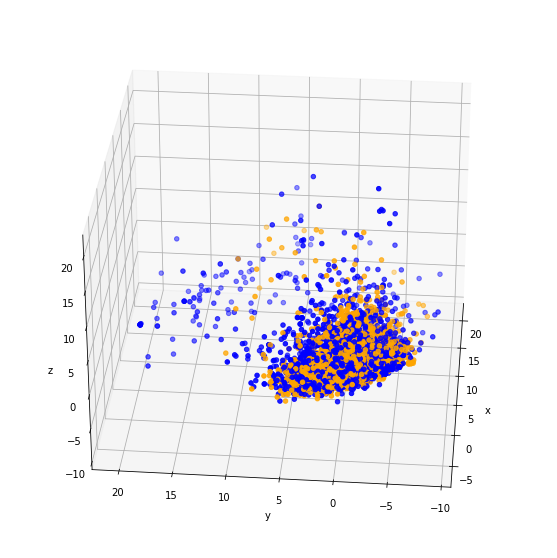

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# from mpl_toolkits import mplot3d
# %matplotlib widget

cmap = matplotlib.colors.ListedColormap(['blue', 'orange'])
plt.figure(figsize=(10,10))
axes = plt.axes(projection='3d')
axes.scatter3D(X_pca[:,0], X_pca[:,1],X_pca[:,2,],
               c=sample_df.label, cmap=cmap)

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
axes.view_init(30, 185)
plt.show()



In [ ]:
import plotly.express as px


fig = px.scatter_3d(sample_df, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
              color='label')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show()

# K-Means Clustering on Tfidf Vectorized Text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer( min_df=20,
                      ngram_range=(1,3)
                      )
X_vec = vec.fit_transform(sample_df['lemmatized_text'])
X_vec_PCA = PCA(n_components=5).fit_transform(X_vec.toarray())

In [ ]:
n_clust_lst = [x for x in range(2,11)]
tf_results = find_best_kmeans(X_vec_PCA,n_clust_lst)

In [ ]:
tf_results

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'score': [0.3502954557217614,
  0.39016667464732474,
  0.29140696914484326,
  0.3193035420582798,
  0.259653259061888,
  0.2577439650141051,
  0.26945999374966784,
  0.26970390452109744,
  0.2717220420851382],
 'best_model': KMeans(n_clusters=2, random_state=99)}

Best Score (tfidf): 0.6093838810920715


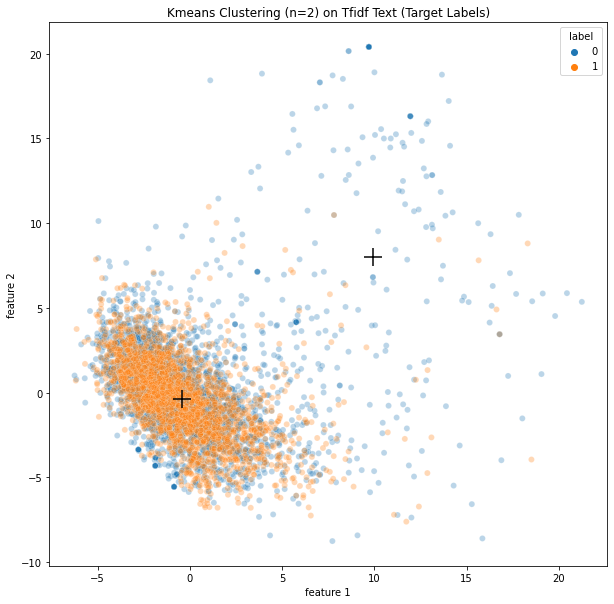

In [ ]:
print(f"Best Score (tfidf): {np.max(results['score'])}")
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Tfidf Text (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
top_sentences_by_cluster(X_vec_PCA,km,sample_df)

 
top 10 closest sentences to cluster 0's center:
Oxygen was independently discovered by Carl Wilhelm Scheele , in Uppsala , in 1773 or earlier , and Joseph Priestley in Wiltshire , in 1774 , but Priestley is often given priority because his publication came out in print first .
They obtained independence in 1960 .
After receiving a first prize in organ performance and improvisation in 1941 , Jeanne Demessieux studied five more years with Dupré in Meudon , before she played her début recital at Salle Pleyel in Paris in 1946 .
This happens at about 1 bit in 1015 in enterprise-class disk drives , and 1 bit in 1014 in ordinary disk drives .
This season was also the first to have a tiebreaker challenge : in , the person that had most votes against them in earlier Tribal Councils was voted out in such a situation , but in Samburus first tribal council , Carl Bilancione and Lindsey Richter each had four votes .
In The Brothers Karamazov , the character Dimitri Karamazov asks his atheist frie

# Numeric Features

In [ ]:
num_features = ['d_chall_score', 'aoa_mean',
       'aoa_min', 'aoa_max', 'conc_rating_mean', 'conc_rating_min',
       'conc_rating_max', 'num_lemmas']

In [ ]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)


In [ ]:
metrics = find_best_kmeans(X_num_std,[2,3,4,5,6,7,8])

In [ ]:
metrics

{'cluster': [2, 3, 4, 5, 6, 7, 8],
 'score': [0.578215750326415,
  0.5827496800305163,
  0.1915945984651341,
  0.22061948770636472,
  0.2286004387003079,
  0.20774957793808052,
  0.19839061540106112],
 'best_model': KMeans(max_iter=500, n_clusters=3, random_state=99)}

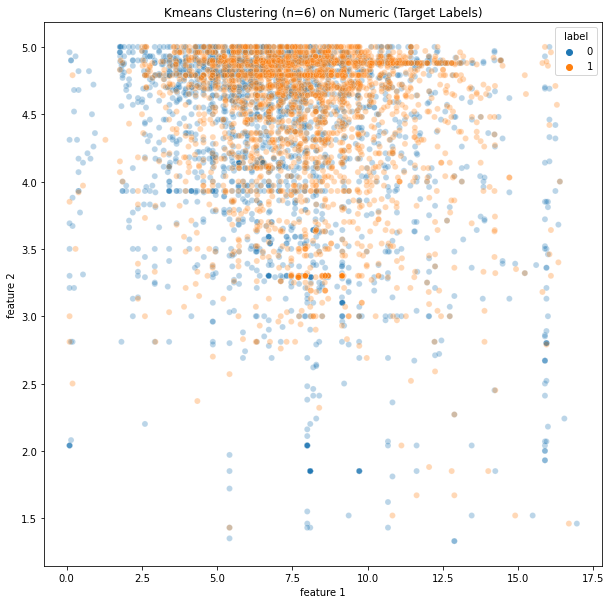

In [ ]:
c_labels = metrics['best_model'].labels_
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Numeric (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=sample_df['d_chall_score'],
                y=sample_df['conc_rating_max'],
                hue=sample_df.label,
                alpha=.3);


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Best Score: 0.5807250572847593


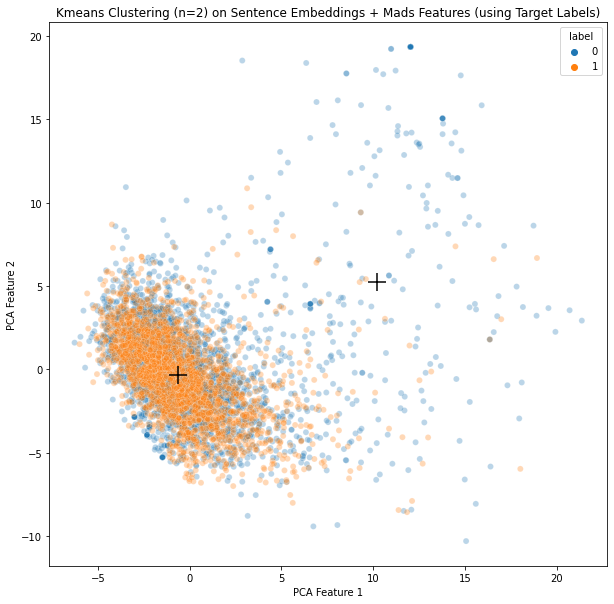

In [ ]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)
num_df = pd.DataFrame(X_num_std, columns=num_features)


X_emb_mads = pd.concat([pd.DataFrame(X_std), num_df], axis=1)
X_em_std = StandardScaler().fit_transform(X_emb_mads)
X_em_pca = PCA(n_components=5).fit_transform(X_em_std)

results = find_best_kmeans(X_em_pca, [x for x in range(2,10)])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
feat_one = X_em_pca[:,0]
feat_two = X_em_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings + Mads Features (using Target Labels)"
plot_clusters(feat_one,
              feat_two,
              sample_df.label, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)


# Using UMAP For Dimensionality-Reduction

In [ ]:
import umap

In [ ]:
# Code obtained and slightly modified from https://umap-learn.readthedocs.io/en/latest/parameters.html

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    data=X_std
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)),c=data[:,0])
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data[:,0])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

In [ ]:
# reducer = umap.UMAP(n_neighbors=5, n_components=2)
# embs = reducer.fit_transform(X_std)

# for n in (2, 5, 10, 20, 50, 100, 200):
#     draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
# %pip install umap-learn
#%pip install "umap-learn[plot]"

In [ ]:
import umap.plot

Text(0.5, 1.0, 'Umap Results with Target Labels')

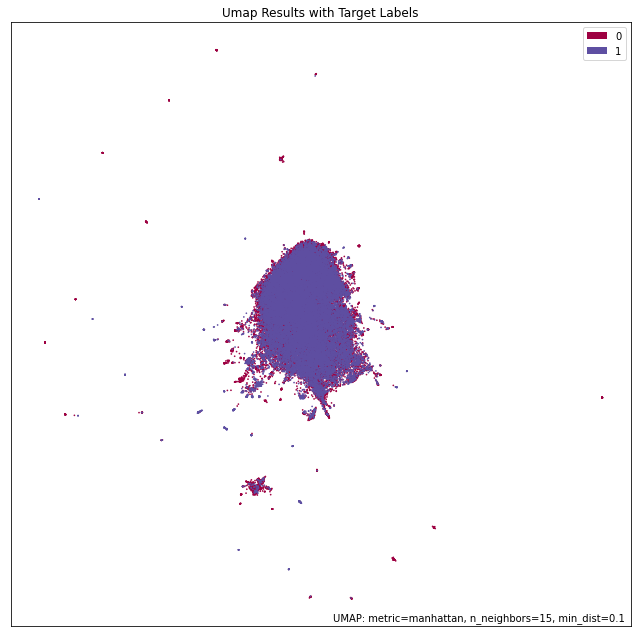

In [ ]:
X_std = StandardScaler().fit_transform(X)
mapper = umap.UMAP(metric='manhattan', random_state=99).fit(X_std)
umap.plot.points(mapper,labels=sample_df.label)
plt.title("Umap Results with Target Labels")

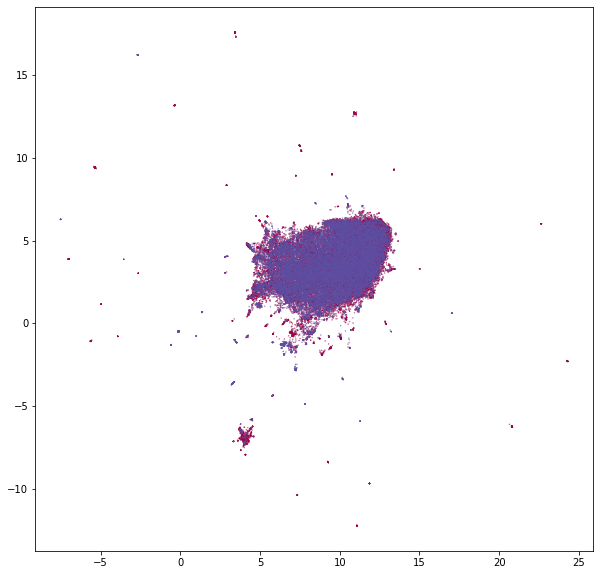

In [ ]:
standard_embedding = umap.UMAP(metric='euclidean',
                               random_state=99).fit_transform(X_std)
plt.figure(figsize=(10,10))
plt.scatter(standard_embedding[:, 0], 
            standard_embedding[:, 1],
            c=sample_df.label, s=0.1, cmap='Spectral')


In [ ]:
def find_best_clus_metric(lst_metrics):

  metrics = {'metric': [],
            'clusters': [],
            'score': []
            }

  clus_range = [x for x in range(2,10)]
  for m in lst_metrics:
    mapping = umap.UMAP(metric=m,
                                random_state=99).fit_transform(X_std)
    results = find_best_kmeans(mapping,clus_range)
    for idx, score in enumerate(results['score']):
      metrics['metric'].append(m)
      metrics['clusters'].append(results['cluster'][idx])
      metrics['score'].append(score)

  return metrics



lst_metrics = ['manhattan', 'euclidean','cosine','correlation']

metrics = find_best_clus_metric(lst_metrics)




In [ ]:
umap_res = pd.DataFrame(metrics)
umap_res.sort_values('score', ascending=False)[:5]

metric  clusters     score
16       cosine         2  0.485775
24  correlation         2  0.480532
26  correlation         4  0.451779
18       cosine         4  0.444049
2     manhattan         4  0.431296

In [ ]:
# None of the kmeans scores using UMAP are better than what we were able to get through standard PCA
# The table above shows the 5 highest silo scores based on the metric passed to UMAP and the best clusters found
# found by k-means. Of the 4 measures used to reduce dimensions, cosine and correlation measures
# produced the highest scores (top 4 of 5)

In [ ]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


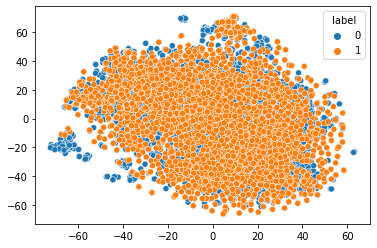

In [ ]:
for lr in [10,100,500,1000]:
  tsne= TSNE(learning_rate = lr,
             random_state=99,
             n_jobs=-1)
  X_tsne = tsne.fit_transform(X_std)
  
  
  
  sns.scatterplot(X_tsne[:,0],X_tsne[:,1], hue=sample_df['label'] )

#Agglomerative Clustering

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
X_std.shape

(10000, 300)

In [ ]:
# code from https://www.projectpro.io/recipes/do-agglomerative-clustering-in-python

clt = AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=5)
model = clt.fit(X_std)
clusters = model.fit_predict(X_std)
sample_df['agg_cluster'] = clusters

In [ ]:
X_pca = PCA(n_components=2, random_state=99).fit_transform(X_std)

In [ ]:
  # fig = plt.figure(figsize=(10,10)); 
  # ax = fig.add_subplot(111)
  # scatter = ax.scatter(X_pca[:,0],X_pca[:,1], c=sample_df.agg_cluster,s=50)
  # ax.set_title(f"Agglomerative Clustering (Ward's Distance n={len(sample_df)}")
  # ax.set_xlabel("X0"); ax.set_ylabel("X1")
  # plt.colorbar(scatter); plt.show()


In [ ]:
def find_best_agg_clusters(X,num_clust):
 
  X_pca = PCA(n_components=2).fit_transform(X)
  m = {'cluster':[],
       'score':[],
       'best_model':None}
  fig, ax = plt.subplots(3,3, figsize=(15,15))
  ax = ax.flatten()
  for idx, k in enumerate(num_clust):
    clt = AgglomerativeClustering(linkage="ward",
                                    affinity='euclidean',
                                    n_clusters=k
                                  )
    model = clt.fit(X_std)
    clusters = model.fit_predict(X_std)
    score = silhouette_score(X_std,clusters,
                    random_state=99)
    

    scatter = ax[idx].scatter(X_pca[:,0],X_pca[:,1], 
                              c=clusters,s=50, cmap='viridis')
    ax[idx].set_title(f"k={k}")
    ax[idx].set_xlabel("X0"); 
    ax[idx].set_ylabel("X1")

    fig.colorbar(scatter, ax=ax[idx])

    m['cluster'].append(k)
    if m['best_model'] == None:
      m['best_model'] = model
    elif score > np.max(m['score']):
      m['best_model'] = model    
    m['score'].append(score)
    


  return m

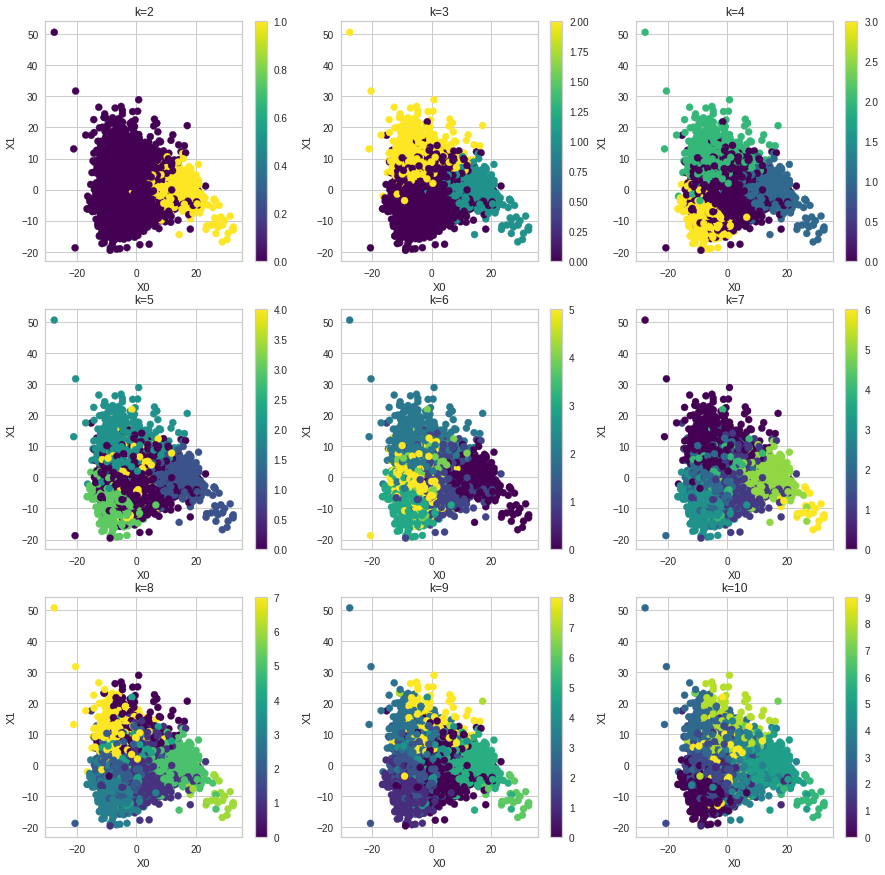

In [ ]:
agg_results = find_best_agg_clusters(X_std,[i for i in range(2,11)])


In [ ]:
agg_results

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'score': [0.14927608,
  0.10102303,
  0.027012281,
  0.02455026,
  0.008621944,
  0.011592865,
  0.014903307,
  0.018786544,
  0.021290213],
 'best_model': AgglomerativeClustering()}

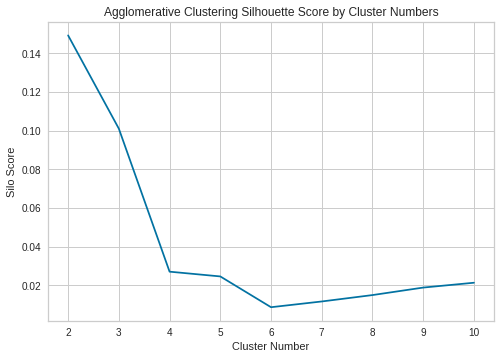

In [ ]:
plt.title("Agglomerative Clustering Silhouette Score by Cluster Numbers")
sns.lineplot(x=agg_results['cluster'],
             y=agg_results['score'])
plt.xlabel('Cluster Number')
plt.ylabel('Silo Score');

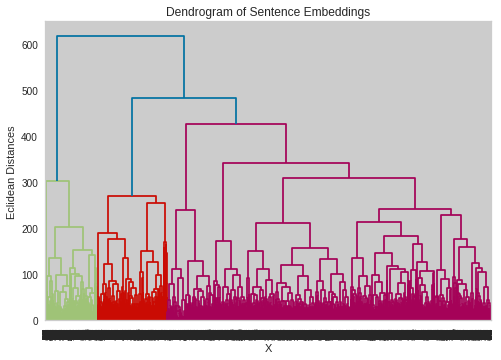

<Figure size 720x720 with 0 Axes>

In [ ]:
import scipy.cluster.hierarchy as sch
cls = sch.ward(X_std)
dendrogram = sch.dendrogram(cls)
plt.title("Dendrogram of Sentence Embeddings")
plt.xlabel("X")
plt.ylabel("Eclidean Distances")
plt.figure(figsize=(10,10))
plt.show()

In [ ]:
# Again it appears that 2 clusters seem to be preferred under this method.  We could possibly evaluate 3 clusters as well

In [ ]:
model = agg_results['best_model']
y_preds = model.fit_predict(X_std)
sample_df["agg_cluster"] = y_preds



In [ ]:
from pandas import option_context
sample_clusters = sample_df.groupby('agg_cluster').apply(lambda x: x.sample(20, random_state=99))
with option_context('display.max_colwidth', 400):
  display(sample_clusters[['original_text', 'agg_cluster']])

original_text  \
agg_cluster ix                                                                                                                                                                                                                                                                                                                                                                                                                        
0           408795                                                                                                                                                                                                                Ongar station remained closed for engineering works and general maintenance and reopened on Sunday 28 May 2006 to passengers . At first though it was not possible to use the station buildings .   
            18613                                                                                                                                                                                                                                                                                 A major difference between the manga and other versions of Team Rocket is that several Gym Leaders are antagonists in the manga .   
            277242                                                                                                                                                                                                                                                                                                                                         Jefferson Ward stores in the northern US were sold to Bradlees in 1985 .   
            217024                                                                                                                                                                                                                                                                                                                       Born as as Alfons Karg , he trained as a telecommunications engineer , but was not happy .   
            317501                                                                                         Toscanini was often criticized for not performing much American music and contemporary music -LRB- music by living composers -RRB- . However , in 1938 , he conducted the world premieres of two orchestral works by Samuel Barber , Adagio for Strings and Essay for Orchestra -LRB- Barber -RRB- Essay for Orchestra .   
            91866                                                                                                                                                                                                                                                                                                          The '' Rundschau '' published its first issue on 1 August 1945 , shortly after the end of World War II .   
            179801  In his dissenting response to Dijkstra 's article and the above '' offensive statement '' , computer scientist Howard E. Tompkins defended structured COBOL : '' COBOL programs with convoluted control flow indeed tend to ` cripple the mind ' '' , but this was because '' there are too many such business application programs written by programmers that have never had the benefit of structured COB...   
            168796                                                                                                                                                                                                                            National Children 's Book and Literacy Alliance website The Patersons continue to live in Barre , Vermont , and Dr. Paterson has retired as pastor of the First Presbyterian Church .   
            295519                                                                                                                                                              

In [ ]:
from sklearn.neighbors import NearestCentroid

In [ ]:
clf = NearestCentroid()
clf.fit(X_std, y_preds)

NearestCentroid()

2

In [ ]:
from scipy.spatial.distance import euclidean


def top_sentences_by_agg_cluster(X,clf,y_pred, df):
  closest_pt_idx = []
  for iclust in range(len(clf.centroids_)):
      # get all points assigned to each cluster:
      cluster_pts = X[y_pred == iclust]
      # get all indices of points assigned to this cluster:
      cluster_pts_indices = np.where(y_pred == iclust)[0]

      cluster_cen = clf.centroids_[iclust]
      top = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[:10]
      bottom = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[-10:]

      print(" ")
      print(f" Cluster {iclust}")
      print("--------------")
      # Print out the results for each cluster:
      print(f" ")
      print(f'top 10 closest sentences to cluster {iclust}\'s center:')
      for i,sent_vec in enumerate(top):
        print(f"{i}. {df.iloc[cluster_pts_indices[sent_vec]]['original_text']}")
      print(" ")
      print(f'farthest sentences to cluster {iclust}\'s center:')
      for i, sent_vec in enumerate(bottom[::-1]):
        print(f"{i}. {df.iloc[cluster_pts_indices[sent_vec]]['original_text']}")

In [ ]:
top_sentences_by_agg_cluster(X_std,clf,y_preds,sample_df)

 
 Cluster 0
--------------
 
top 10 closest sentences to cluster 0's center:
0. Pantomime -LRB- informally , panto -RRB- , not to be confused with a mime artist , referring to a theatrical performer of mime , is a musical-comedy theatrical production traditionally found in the United Kingdom , Australia , Canada , Jamaica , South Africa , Japan , India , Ireland , Gibraltar and Malta , and is mostly performed during the Christmas and New Year season .
1. Written by Buffy creator Joss Whedon , the series follows a Slayer named Melaka Fray , a chosen one in a time where vampires -LRB- called '' lurks '' -RRB- are returning to the slums of New York City , and the rich-poor divide is even greater .
2. Two days later , it was reported on RTE News that the original Setanta Sports channel Setanta Ireland might be bought out by an existing consortium who already hold interests in Setanta Sport Holdings Ltd the Irish arm of Setanta Sports . Setanta Sports Ireland and Setanta Sports North Ameri

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=1)
cls = dbscan.fit_predict(X_std)

In [ ]:
labels=dbscan.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

Estimated no. of clusters: 9473


In [ ]:
silhouette_score(X_std, labels, random_state=99)

0.07155304